<a href="https://colab.research.google.com/github/geovatatsuga/webscraping-jiujitsu-data-analise/blob/main/relatorio_jiujitsu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documentaçao do projeto

### Inrodução:

No âmbito do jiu-jitsu, é amplamente reconhecido que as posições de domínio máximo são a pegada de costas e a montada. Essas posições, em especial a pegada de costas, proporcionam vantagens técnicas significativas, permitindo um controle eficiente e a execução de finalizações com alto grau de efetividade. Diante disso, este projeto tem como objetivo central investigar e elucidar as seguintes questões:


*   Quais são as finalizações mais frequentes em competições de jiu-jitsu?

*   Como se distribuem as finalizações ao longo das lutas?

*   Quantas finalizações são realizadas a partir da posição de costas e qual a sua porcentagem em relação às demais finalizações?

Para responder a essas questões, foram analisadas mais de 15 mil lutas de competições de jiu-jitsu, abrangendo diferentes níveis de habilidade, categorias de peso e faixas etárias. Essa extensa base de dados permitiu uma análise estatística robusta, possibilitando identificar padrões, tendências e distribuições das finalizações mais recorrentes.


A partir desses questionamentos, busca-se compreender melhor a dinâmica das finalizações no contexto competitivo do jiu-jitsu, contribuindo para um entendimento mais aprofundado das estratégias e técnicas predominantes nesse esporte.


### Definição do problema

Este projeto tem como objetivo principal a prática dos fundamentos de análise de dados utilizando Python, empregando técnicas como manipulação, limpeza e visualização de dados.

Embora o foco seja o aprendizado técnico, o conjunto de dados analisado permite responder a perguntas relevantes relacionadas ao seu contexto.



### Coleta e armazenamento de dados
A coleta de dados foi realizada por meio de técnicas de web scraping aplicadas ao site **bjjheroes.com**. Utilizou-se a biblioteca requests para realizar requisições HTTP e obter o conteúdo das páginas, e a **BeautifulSoup** para fazer o parse do HTML e extrair as informações relevantes, como os nomes dos lutadores e as contagens das finalizações.

Para otimizar o processo, foi implementado uma sessão persistente com **requests.Session(**), que minimiza a latência das requisições, e utilizamos o **ThreadPoolExecutor** do módulo concurrent.futures para processar os dados dos lutadores em paralelo. Essa abordagem acelerou significativamente a coleta das informações.

Após a extração, os dados foram organizados em um DataFrame com a biblioteca pandas, onde cada linha representa uma técnica de finalização e sua respectiva contagem. Por fim, os dados foram salvos em um arquivo **CSV**, permitindo fácil acesso e manipulação para análises posteriores.

Ferramentas Utilizadas:


*   **BeautifulSoup**: Para extração dos dados do HTML.
*   **requests**: Para requisições HTTP.
*   **pandas**: Para organização, manipulação e armazenamento dos dados.
*   **ThreadPoolExecutor**: Para processamento paralelo e otimização do scraping.
*   **tqdm**: Para monitoramento do progresso das requisições.
*   **fuzzy matching**: Correção automatizada de erros usando correspondência aproximada identificando e agrupando termos semelhantes.
  



In [19]:
pip install fuzzywuzzy python-Levenshtein

In [20]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Insalando todas as bibliotecas.

**Observação**

O processo de webscraping foi implementado de modo a gerar automaticamente um dataframe atualizado sempre que o script for executado. No entanto, para aqueles que preferirem não executar o script, os dataframes já processados estarão disponíveis para utilização direta.

Caso opte por não realizar a execução do webscraping, é possível avançar diretamente para a etapa de visualização dos dados, onde os dataframes pré-compilados estarão acessíveis para análise e interpretação.

**Sumário:**

Choke from back – Estrangulamento pelas costas (COM GI)

Armbar – Chave de braço

RNC – Rear Naked Choke (Mata leão)

Triangle – Triângulo

Inside heel hook – Chave de calcanhar

Kneebar – Chave de joelho

Toe hold – Mata leão de pé

Straight ankle lock – Chave de tornozelo reta

Katagatame – Katagatame

Botinha – Botinha (Chave de pé reta)

Guillotine – Guilhotina

Bow and arrow – Arco e flecha

Kimura – Kimura

Outside heel hook – Chave de calcanhar externa

Cross choke – Estrangulamento cruzado

Arm in Ezekiel – Ezekiel com braço inserido

Footlock – Chave de pé

Triangle armbar – Triângulo com chave de braço

Heel hook – Chave de calcanhar (genérico)

Omoplata – Omoplata (Chave de ombro)

In [21]:
# Dicionário para armazenar as submissões e suas contagens
submission_counts = {}
fighter_roster = []
session = requests.Session()  # Sessão persistente para reduzir latência

def add_submission(submission, count):
    # Atualiza o dicionário de submissões somando o valor fornecido."""
    submission_counts[submission] = submission_counts.get(submission, 0) + int(count)

def get_fighters():
    #Coleta a lista de lutadores e processa cada um para extrair suas submissões.
    url = "https://www.bjjheroes.com/a-z-bjj-fighters-list"
    response = session.get(url, timeout=10)
    if response.status_code != 200:
        print("Erro ao acessar a lista de lutadores.")
        return []
    soup = BeautifulSoup(response.content, 'html.parser')

    first_names = soup.find_all("td", class_='column-1')
    last_names = soup.find_all("td", class_='column-2')

    return [f"{first.get_text(strip=True)}-{last.get_text(strip=True)}" for first, last in zip(first_names, last_names)]

def scrape_fighter(fighter):
    # Extrai as submissões e seus valores para um lutador específico.
    url = f"https://www.bjjheroes.com/bjj-fighters/{fighter}"
    try:
        response = session.get(url, timeout=5)  # Timeout para evitar bloqueios
        if response.status_code != 200:
            return f"Erro ao acessar o lutador: {fighter}"
        soup = BeautifulSoup(response.content, 'html.parser')

        submission_texts = soup.find_all("div", class_='text')
        submission_values = soup.find_all("div", class_='totalvalue')

        for text_div, value_div in zip(submission_texts, submission_values):
            submission = text_div.get_text(strip=True)
            count = value_div.get_text(strip=True)
            add_submission(submission, count)
        return None
    except requests.exceptions.RequestException:
        return f"Erro ao acessar o lutador: {fighter}"

def process_fighters(fighter_list, max_workers=10):
    # Processa lutadores em paralelo usando ThreadPoolExecutor.
    errors = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(scrape_fighter, fighter): fighter for fighter in fighter_list}
        for future in tqdm(as_completed(futures), total=len(fighter_list), desc="Processando lutadores", unit="lutador"):
            error = future.result()
            if error:
                errors.append(error)

def save_submissions_to_csv(filename='submission_counts.csv'):
    # Salva os dados de submissões em um arquivo CSV.
    if submission_counts:
        df = pd.DataFrame(list(submission_counts.items()), columns=['Submission', 'Count'])
        df.to_csv(filename, index=False)
        print(f"Contagens de submissões salvas em {filename}")
    else:
        print("Nenhuma submissão encontrada para salvar.")

if __name__ == '__main__':
    fighters = get_fighters()  # Coleta a lista de lutadores
    if fighters:
        process_fighters(fighters, max_workers=10)  # Processa lutadores em paralelo
        save_submissions_to_csv()  # Salva o resultado final em CSV


Processando lutadores: 100%|██████████| 1384/1384 [03:07<00:00,  7.37lutador/s]

Contagens de submissões salvas em submission_counts.csv



*   Visualizando DataFrame



In [22]:
caminho_dados = '/content/submission_counts.csv'
dfFinalizaçoes = pd.read_csv(caminho_dados)

dfFinalizaçoes

,Submission,Count
0,Heel hook,121
1,RNC,1632
2,Armbar,2391
3,Mounted triangle,23
4,Kimura,257
...,...,...
247,Injury,1
248,Necktie,1
249,Trianglle,1
250,Knee on belly/choke,1


### Preparação e limpeza de dados

A etapa de preparação e limpeza dos dados foi fundamental para garantir a integridade e a precisão da análise. O conjunto inicial apresentava desafios como inconsistências de grafia (ex.: "Heel Hook" vs. "Heel hook"), erros de digitação (ex.: "Straignt ankle lock") e termos genéricos ou redundantes (ex.: "Submission" sem contexto).

Para resolver essas questões, foram aplicadas técnicas como:

Padronização de nomenclaturas, consolidando variações (ex.: "Choke from back" e "Choke from Back").

Correção automatizada de erros usando correspondência aproximada (fuzzy matching), identificando e agrupando termos semelhantes.

Remoção de entradas não técnicas (ex.: "TKO", "DQ") para focar em finalizações válidas.


In [23]:
import pandas as pd
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import unicodedata

# Configurações
THRESHOLD = 90  # Similaridade mínima para considerar match
REMOVER_TERMOS = ["submission", "choke", "pressure", "verbal tap", "tko", "advantages", "injury", "exhaustion"]

# Carregar dados
df = pd.read_csv("submission_counts.csv")

# Pré-processamento: normalizar texto
def clean_text(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return text.strip().lower()

# Criar lista de termos únicos como referência
unique_terms = df['Submission'].unique().tolist()
unique_terms_clean = [clean_text(term) for term in unique_terms]

# Dicionário para mapeamento
term_map = {}

# Gerar correspondências fuzzy
for term in df['Submission'].unique():
    cleaned_term = clean_text(term)
    match, score = process.extractOne(cleaned_term, unique_terms_clean, scorer=fuzz.token_sort_ratio)

    if score >= THRESHOLD:
        original_match = unique_terms[unique_terms_clean.index(match)]
        term_map[term] = original_match
    else:
        term_map[term] = term

# Aplicar correções
df['Submission_Corrected'] = df['Submission'].map(term_map)

# Remover termos genéricos
df = df[~df['Submission_Corrected'].str.lower().isin([t.lower() for t in REMOVER_TERMOS])]

# Agrupar e somar
df_final = df.groupby('Submission_Corrected', as_index=False)['Count'].sum()

# Ordenar e formatar
df_final = df_final.sort_values('Count', ascending=False).reset_index(drop=True)
df_final.columns = ['Submission', 'Count']

# Salvar resultado
df_final.to_csv("submissions_clean_fuzzy.csv", index=False)

print(f"Total original: {len(df)} → Total corrigido: {len(df_final)}")
df_final

Total original: 242 → Total corrigido: 198


,Submission,Count
0,Choke from back,2622
1,Armbar,2392
2,RNC,1632
3,Triangle,1049
4,Inside heel hook,703
...,...,...
193,Marcelotine,1
194,Marceloplata,1
195,Lens lock,1
196,Body choke,1


O processo resultou em uma redução de entradas (de **242** para **198**), transformando os dados em uma base consistente e pronta para análise.

 A limpeza não apenas otimizou a qualidade do dataset, mas também garantiu que insights subsequentes fossem confiáveis e acionáveis, refletindo as técnicas reais utilizadas no contexto do projeto.

### Anáise exploratória de dados

Inicialmente, iremos reduzir o numero de finalizações até o TOP 20 das com mais contagens, estas por si só representam 80% da quantidade total de contagens,

In [24]:
top20df = df_final.head(20)
top20df

,Submission,Count
0,Choke from back,2622
1,Armbar,2392
2,RNC,1632
3,Triangle,1049
4,Inside heel hook,703
5,Kneebar,658
6,Toe hold,630
7,Straight ankle lock,493
8,Katagatame,444
9,Botinha,441


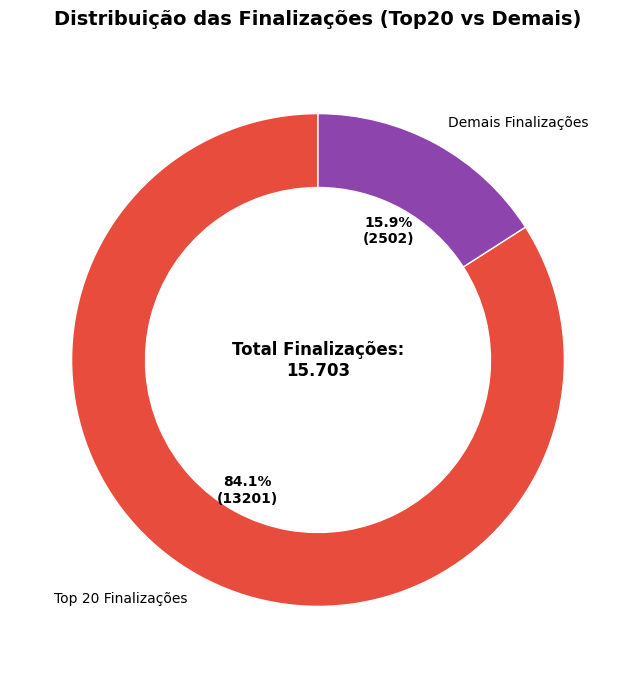

In [25]:
import matplotlib.pyplot as plt
totaltop20 = top20df['Count'].sum()

totalfinalizacoes = df_final['Count'].sum()
demais_finalizacoes = totalfinalizacoes - totaltop20  # Finalizações fora do Top20

# Rótulos e valores
labels = ['Top 20 Finalizações', 'Demais Finalizações']
sizes = [totaltop20, demais_finalizacoes]

# Função de formatação
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        absolute = int(round(pct * total / 100.0))
        return '{:.1f}%\n({:d})'.format(pct, absolute)
    return my_autopct

# Criação do gráfico com novas cores
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    wedgeprops={'width':0.3, 'edgecolor':'white'},
    colors=['#e74c3c', '#8e44ad']  # Novas cores
)

# Texto central
ax.text(0, 0, f'Total Finalizações:\n{totalfinalizacoes:,}'.replace(",", "."),
        ha='center', va='center', fontsize=12, fontweight='bold')

# Ajustes estéticos
plt.setp(autotexts, size=10, weight='bold')  # Formata números
plt.setp(texts, size=10)  # Formata labels

ax.set_title('Distribuição das Finalizações (Top20 vs Demais)',
            fontsize=14, pad=20, fontweight='bold')
plt.show()


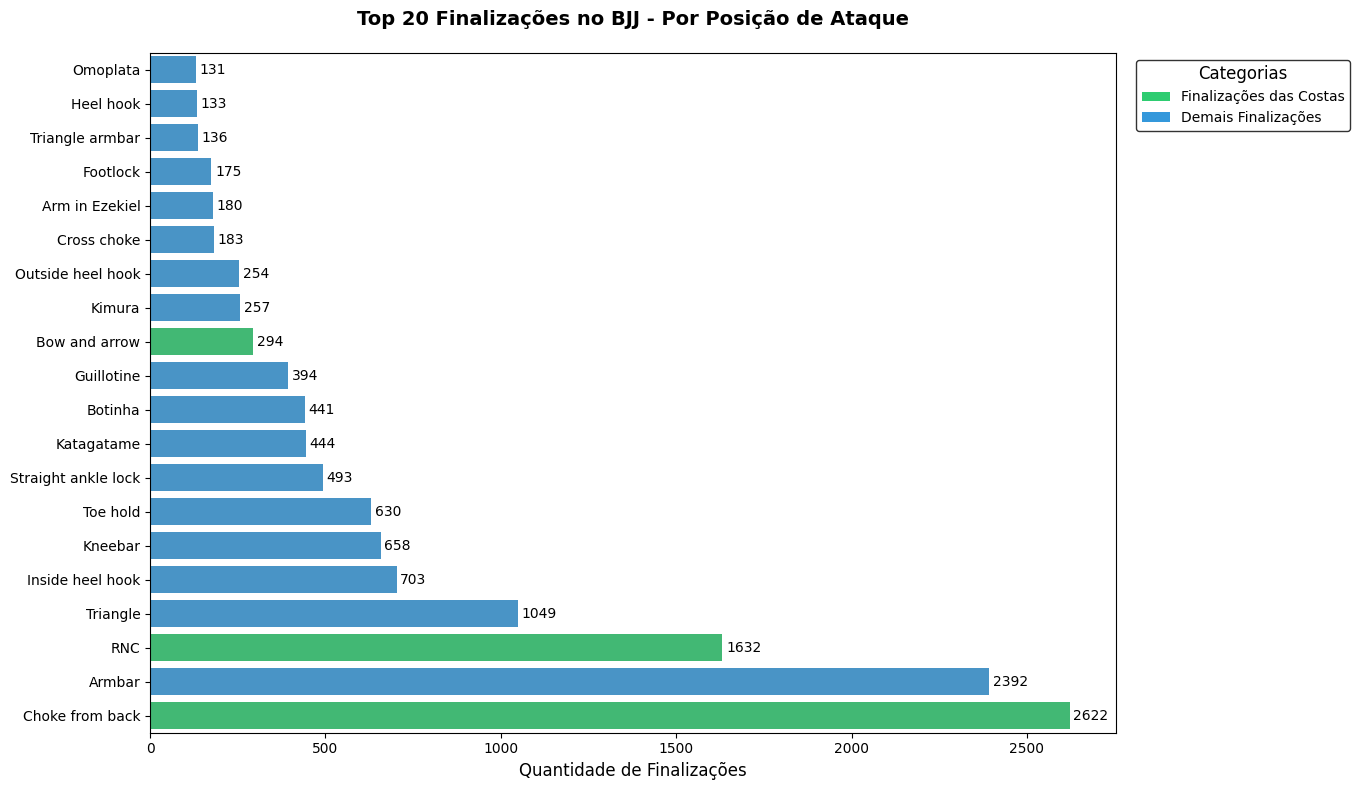

In [26]:
from matplotlib.patches import Patch
import seaborn as sns

# Lista de finalizações que partem das costas
finalizacoes_costas = ["Choke from back", "RNC", "Bow and arrow"]

# Criar cópia explícita do DataFrame
top20df = top20df.copy()

# Criar coluna de categoria
top20df.loc[:, "Categoria"] = ["Costas" if sub in finalizacoes_costas else "Outras"
                              for sub in top20df["Submission"]]

# Ordenar os dados
top20df = top20df.sort_values(by="Count", ascending=True)

# Configurar o gráfico
plt.figure(figsize=(14, 8))  # Aumentei um pouco o tamanho
ax = sns.barplot(
    x="Count",
    y="Submission",
    hue="Categoria",
    data=top20df,
    palette={"Costas": "#2ecc71", "Outras": "#3498db"},
    dodge=False,
    legend=False
)

# Título e labels
plt.title("Top 20 Finalizações no BJJ - Por Posição de Ataque",
          fontsize=14, fontweight="bold", pad=20)
plt.xlabel("Quantidade de Finalizações", fontsize=12)
plt.ylabel("")

# Valores nas barras
for index, value in enumerate(top20df["Count"]):
    ax.text(value + 10, index, str(value), va="center", fontsize=10)

# Legenda personalizada no canto superior direito
legend_elements = [
    Patch(facecolor='#2ecc71', label='Finalizações das Costas'),
    Patch(facecolor='#3498db', label='Demais Finalizações')
]

ax.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.25, 1),  # Posicionamento ajustado
    frameon=True,
    edgecolor='black',
    title='Categorias',
    title_fontsize='12'
)

plt.tight_layout()
plt.show()

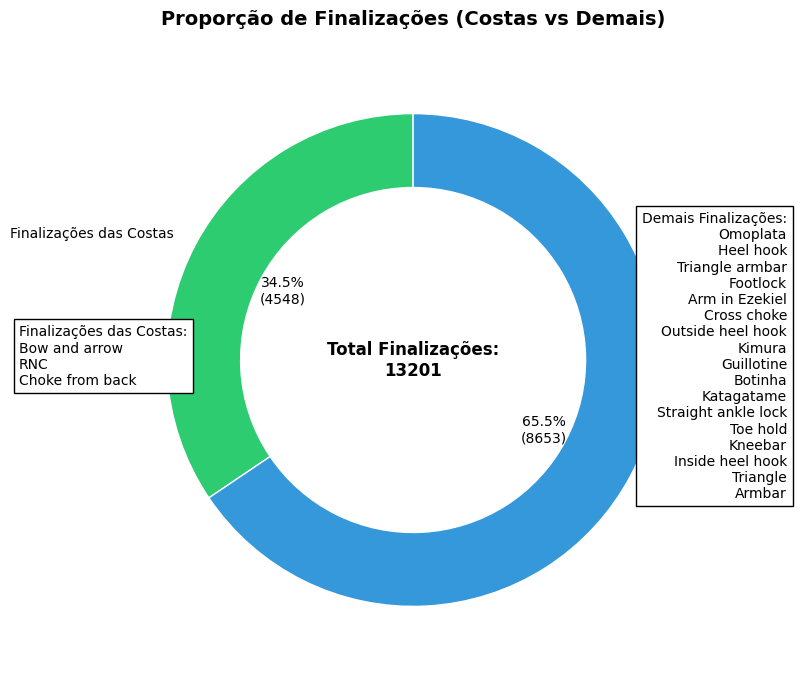

In [31]:

import matplotlib.pyplot as plt

# Lista de finalizações que partem das costas
finalizacoes_costas = ["Choke from back", "RNC", "Bow and arrow"]

# Cria uma cópia explícita do DataFrame
top20df = top20df.copy()

# Cria coluna de categoria
top20df.loc[:, "Categoria"] = [
    "Costas" if sub in finalizacoes_costas else "Outras"
    for sub in top20df["Submission"]
]

# Calcula os totais para cada categoria
total_costas = top20df.loc[top20df["Categoria"] == "Costas", "Count"].sum()
total_outras = top20df.loc[top20df["Categoria"] == "Outras", "Count"].sum()
total_finalizacoes = total_costas + total_outras

# Rótulos e valores
labels = ['Finalizações das Costas', 'Demais Finalizações']
sizes = [total_costas, total_outras]

# Função de formatação para exibir porcentagem e valor absoluto
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        absolute = int(round(pct * total / 100.0))
        return '{:.1f}%\n({:d})'.format(pct, absolute)
    return my_autopct

# Criação do gráfico donut com as cores da paleta do barplot
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    wedgeprops={'width': 0.3, 'edgecolor': 'white'},
    colors=['#2ecc71', '#3498db']
)

# Texto central com o total de finalizações
ax.text(0, 0, f'Total Finalizações:\n{total_finalizacoes}',
        ha='center', va='center', fontsize=12, fontweight='bold')

# Título do gráfico
ax.set_title('Proporção de Finalizações (Costas vs Demais)',
             fontsize=14, pad=20, fontweight='bold')

# Preparar os textos para as categorias:
# Listar as finalizações de "Costas"
costas_submissions = top20df.loc[top20df["Categoria"] == "Costas", "Submission"].unique()
costas_text = "Finalizações das Costas:\n" + "\n".join(costas_submissions)

# Listar as demais finalizações
demais_submissions = top20df.loc[top20df["Categoria"] == "Outras", "Submission"].unique()
demais_text = "Demais Finalizações:\n" + "\n".join(demais_submissions)

# Adiciona os textos na figura, nas laterais
fig.text(0.02, 0.5, costas_text, ha="left", va="center", fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black'))
fig.text(0.98, 0.5, demais_text, ha="right", va="center", fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

### Entrega do Resultado


1.   **Quais são as finalizações mais frequentes em competições de jiu-jitsu?**




Em primeiro lugar, a finalização mais frequente identificada nas competições de jiu-jitsu é o

*  **Choke From the Back, com 2.622 ocorrências.**

Em seguida, destaca-se o

* **Armbar, com 2.392 ocorrências**.

e em terceiro lugar

*  **RNC ( Rear Naked Choke), com 1.632 ocorrências.**

Essas três técnicas representam as finalizações mais utilizadas e eficazes no cenário competitivo.


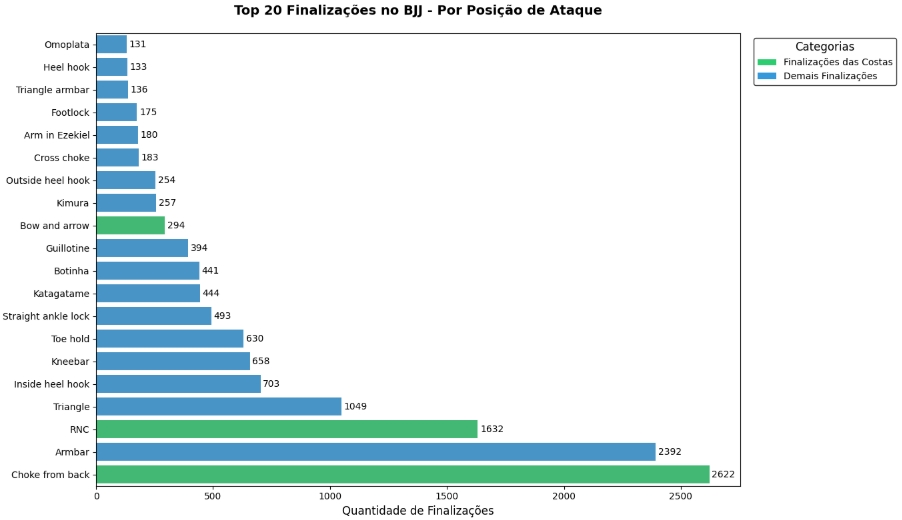





2. **Como se distribuem as finalizações ao longo das lutas?**

A análise da distribuição das finalizações, com base nos dados fornecidos, revela que:

As 20 finalizações com maiores ocorrencias em competições Representam 84,1% do total de finalizações registradas, com 13.201 ocorrências (do total de 15.703).

Demais Finalizações: Correspondem a 15,9% do total, com 2.502 ocorrências.

A concentração nas 20 técnicas mais frequentes (84,1%) indica uma forte padronização no repertório técnico utilizado em competições, com ênfase em finalizações clássicas e altamente eficazes.

As demais finalizações (15,9%) abrangem técnicas menos frequentes ou situacionais, o que sugere uma diversidade estratégica complementar, porém secundária, no cenário competitivo.

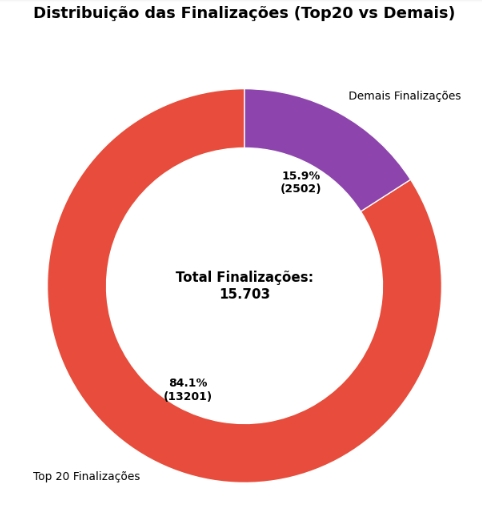


3.   **Quantas finalizações são realizadas a partir da posição de costas e qual a sua porcentagem em relação às demais finalizações?**

A análise quantitativa indica que, dentro do universo de 13.201 finalizações, aproximadamente um terço (34,5%) ocorre a partir da posição de costas. Em termos probabilísticos, ao selecionar aleatoriamente 10 finalizações, espera-se que cerca de 3,45 sejam realizadas a partir das costas e 6,55 a partir de outras posições.

**Cerca de 1 em cada 3 finalizações ocorre a partir da posição de costas.**

 Essa distribuição sugere que, embora a técnica de finalizar a partir da posição de costas seja significativa, o repertório técnico adotado nas lutas é majoritariamente composto por finalizações executadas a partir de outras posições.


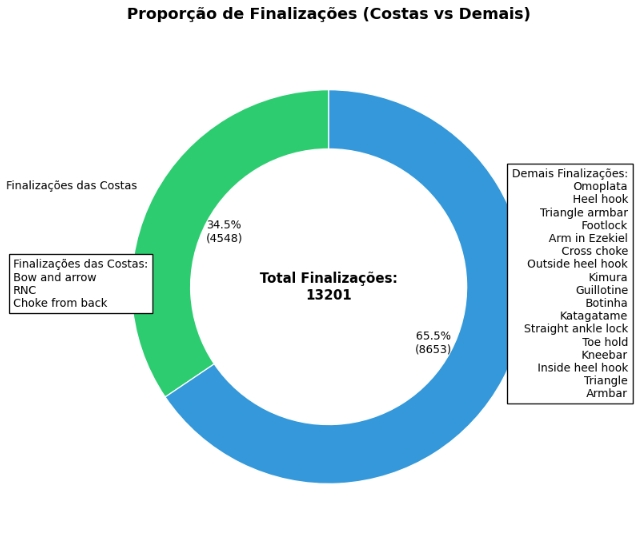

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Certifique-se de ter o kaleido instalado:
# pip install -U kaleido

# Lista de finalizações que partem das costas
finalizacoes_costas = ["Choke from back", "RNC", "Bow and arrow"]

# Cria uma cópia explícita do DataFrame
top20df = top20df.copy()

# Cria a coluna de categoria
top20df["Categoria"] = top20df["Submission"].apply(
    lambda sub: "Costas" if sub in finalizacoes_costas else "Outras"
)

# Calcula os totais para cada categoria
total_costas = top20df.loc[top20df["Categoria"] == "Costas", "Count"].sum()
total_outras = top20df.loc[top20df["Categoria"] == "Outras", "Count"].sum()
total_finalizacoes = total_costas + total_outras

# Rótulos, valores e cores
labels = ['Finalizações das Costas', 'Demais Finalizações']
sizes = [total_costas, total_outras]
colors = ['#2ecc71', '#3498db']

# Criação do gráfico donut com Plotly
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=sizes,
    hole=0.3,
    textinfo='label+percent',
    texttemplate="%{percent:.1%}<br>(%{value})",
    marker=dict(
        colors=colors,
        line=dict(color='white', width=2)
    ),
    rotation=90  # Define o ângulo inicial
)])

# Anotação central com o total de finalizações
fig.add_annotation(dict(
    text=f'Total Finalizações:<br>{total_finalizacoes}',
    x=0.5, y=0.5,
    font_size=12,
    font_color='black',
    showarrow=False,
    xref="paper", yref="paper",
    align="center"
))

# Preparar os textos para as anotações laterais:
# Lista de finalizações de "Costas"
costas_submissions = top20df.loc[top20df["Categoria"] == "Costas", "Submission"].unique()
costas_text = "Finalizações das Costas:<br>" + "<br>".join(costas_submissions)

# Lista de demais finalizações
demais_submissions = top20df.loc[top20df["Categoria"] == "Outras", "Submission"].unique()
demais_text = "Demais Finalizações:<br>" + "<br>".join(demais_submissions)

# Anotações laterais ajustadas para ficarem mais próximas do gráfico
fig.add_annotation(dict(
    text=costas_text,
    x=0.15, y=0.5,  # Anteriormente x=0, agora aproximado do gráfico
    xanchor='left', yanchor='middle',
    font_size=10,
    showarrow=False,
    xref="paper", yref="paper",
    bordercolor="black", borderwidth=1, bgcolor="white"
))
fig.add_annotation(dict(
    text=demais_text,
    x=0.85, y=0.5,  # Anteriormente x=1, agora aproximado do gráfico
    xanchor='right', yanchor='middle',
    font_size=10,
    showarrow=False,
    xref="paper", yref="paper",
    bordercolor="black", borderwidth=1, bgcolor="white"
))

# Configuração do layout com margens mais compactas
fig.update_layout(
    title_text='Proporção de Finalizações (Costas vs Demais)',
    title_x=0.5,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Salva a figura como imagem PNG
fig.write_image("finalizacoes_chart.png")

# Exibe o gráfico interativo
fig.show()
